# semantic segmentation with PyTorch

## import libraries

In [1]:
# . . import libraries
import os
from pathlib import Path
# . . pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision

# . . numpy
import numpy as np
# . . scikit-learn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# , , pandas
import pandas as pd
# . . matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as npimg
# . .  set this to be able to see the figure axis labels in a dark theme
from matplotlib import style

# . . for model summary
from torchsummary import summary

# . . for idential transformation the image and mask
import albumentations as transforms

# . . import libraries by tugrulkonuk
import utils
from dataset import TGSSaltDataset
from model import *
from trainer import Trainer
from callbacks import ReturnBestModel, EarlyStopping


# set device and precision

In [2]:
# . . set the device
if torch.cuda.is_available():  
    device = torch.device("cuda")  
else:  
    device = torch.device("cpu")      

#device = torch.device("cpu")      
# . . set the default tensor to cuda: DO NOT USE THIS
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
# . . set the default precision
dtype = torch.float32

# . . use cudnn backend for performance
torch.backends.cudnn.benchmark = True

torch.backends.cudnn.enabled = True

In [3]:
# . . arguments . .
# . . this is only for the Jupyter notebook as there is no command line
class Args():
    # . . number of epochs 
    epochs = 100
    # . . the learning rate 
    lr = 0.001

    # . . batch_size
    batch_size = 16

    # . . fraction of data to be used in training
    train_size = 0.8

    # . . min delta (min improvement) for early stopping
    min_delta = 0.0005

    # . . patience for early stopping
    patience = 20

    # . . number of workers for the data loader
    num_workers = 8

    # . . use pinn memory for faster CPU-GPU transler
    pin_memory = False

    # . . print interval
    jprint = 1



In [4]:
# . . instantiate the command-line parameters object
args = Args()

# . . get command-line parameters
num_epochs    = args.epochs
batch_size    = args.batch_size
learning_rate = args.lr
train_size    = args.train_size
min_delta     = args.min_delta
patience      = args.patience 
num_workers   = args.num_workers
pin_memory    = args.pin_memory
jprint        = args.jprint

## import the data


In [5]:
# . . data root path
dataroot = '../adversarial-semi-supervised-semantic-segmentation/competition_data'
# . . path for training data
trainpath = dataroot+'/train'
# . . validation data
testpath = dataroot+'/test'

# . . transformer for data augmentation
#transformer_train = transforms.Compose([
#                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#                    transforms.RandomCrop(32, padding=4),
#                    transforms.RandomHorizontalFlip(p=0.5),
#                    transforms.RandomRotation(degrees=15),
#                    transforms.RandomAffine(0, translate=(0.1, 0.1)),
#                    transforms.RandomPerspective(),
#                    transforms.ToTensor(),                                            
#                  ])

transform = transforms.Compose([
            transforms.HorizontalFlip(p=0.5),
            transforms.VerticalFlip(p=0.5),
            transforms.Rotate(limit=45, p=0.5),                                      
          ])


# . . get the list of files
allfiles = utils.get_file_list(trainpath+'/images')
allidx = np.linspace(0, len(allfiles)-1, len(allfiles), dtype=np.int)

train_idx, valid_idx = train_test_split(allidx, test_size=0.2, shuffle=True)
train_idx = np.unique(train_idx)
valid_idx = np.unique(valid_idx)


train_files = np.array(allfiles)[train_idx]
valid_files = np.array(allfiles)[valid_idx]


#train_files = utils.get_file_list(trainpath+'/images')
test_files = utils.get_file_list(testpath+'/images')

# . . read depths 
depths = pd.read_csv(dataroot+'/depths.csv')

# . . the training set
train_dataset = TGSSaltDataset(trainpath, train_files, transform=None, mask=True, imgsize=(128,128), grayscale=True)

# . . the validation set
valid_dataset = TGSSaltDataset(trainpath, valid_files, transform=None, mask=True, imgsize=(128,128), grayscale=True)

# . . the test set
test_dataset = TGSSaltDataset(testpath, test_files, transform=None, mask=False, imgsize=(128,128), grayscale=True)


## data loaders

In [6]:
# . . the training loader: shuffle
trainloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=num_workers, pin_memory=pin_memory)

# . . the test loader: no shuffle
validloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=pin_memory)

In [7]:
# . . test the loader by retrieveing the batch info 
utils.batchinfo(trainloader, label=True)
utils.batchinfo(validloader, label=True)

------------------
There are 200 batches in the dataset
For one iteration (batch), there are:
Data:    torch.Size([16, 1, 128, 128])
Label:   torch.Size([16, 1, 128, 128])
------------------
------------------
There are 50 batches in the dataset
For one iteration (batch), there are:
Data:    torch.Size([16, 1, 128, 128])
Label:   torch.Size([16, 1, 128, 128])
------------------


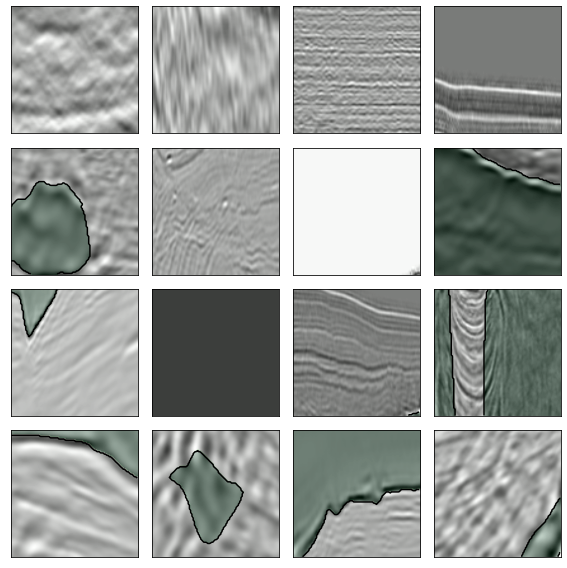

In [8]:
# . . plot some images
images, masks = next(iter(trainloader))
utils.plot_masks(images, masks, 4, 4, figsize=(2,2))

In [9]:
# . . instantiate the model
#model = AttentionUNet()

# . . use the parabolic network
# . . the time step
h = 1e-1
# . . the network geometry
NG = [ 1,  64 , 128, 128, 128,
       64, 128, 128, 128, 128 ]
NG = np.reshape(NG, (2,-1))
# .  weights for the classifier
W = torch.rand(1, NG[-1, -1], 1, 1)*1e-3
# . . weights for the CNN
#K,L = net.init_weights(L_mode='laplacian')
## . . the parabolic CNN model       
model = PackNet(h, NG, L_mode='rand',device=device)
# . . send model to device (GPU)
model.to(device)

PackNet(
  (K): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 64x1x3x3 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 128x64x3x3 (GPU 0)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 128x128x3x3 (GPU 0)]
      (3): Parameter containing: [torch.cuda.FloatTensor of size 128x128x3x3 (GPU 0)]
      (4): Parameter containing: [torch.cuda.FloatTensor of size 128x128x3x3 (GPU 0)]
  )
  (L): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 64x1x3x3 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 128x1x3x3 (GPU 0)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 128x1x3x3 (GPU 0)]
      (3): Parameter containing: [torch.cuda.FloatTensor of size 128x1x3x3 (GPU 0)]
      (4): Parameter containing: [torch.cuda.FloatTensor of size 128x1x3x3 (GPU 0)]
  )
)

In [10]:
# . . show a summary of the model
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           PackNet-1          [-1, 1, 128, 128]               0
Total params: 0
Trainable params: 0
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.12
Params size (MB): 0.00
Estimated Total Size (MB): 0.19
----------------------------------------------------------------



(0, 0)

In [11]:
#out, enorm = model(images.to(device), enorm=True)

In [12]:
#plt.imshow(images[10].squeeze())

In [13]:
#plt.imshow(enorm[10].detach().cpu().numpy().squeeze())

In [14]:
# . . create the trainer
trainer = Trainer(model, device)

# . . compile the trainer
# . . define the loss
criterion = nn.BCEWithLogitsLoss()

# . . define the optimizer
optimparams = {'lr':learning_rate
              }

# . . define the callbacks
cb=[ReturnBestModel(monitor='valid_loss'), EarlyStopping(monitor='valid_loss', min_delta=min_delta, patience=patience)]

trainer.compile(optimizer='adam', criterion=criterion, callbacks=cb, jprint=jprint, **optimparams)

# . . the learning-rate scheduler
schedulerparams = {'factor':0.5,
                   'patience':5,
                   'threshold':1e-5,
                   'cooldown':5,
                   'min_lr':1e-4,                
                   'verbose':True               
                  }
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(trainer.optimizer, **schedulerparams)

In [15]:
# . . train the network
train_loss, valid_loss = trainer.fit(trainloader, validloader, scheduler=scheduler, num_epochs=num_epochs)

Training started:  March 04, 2021 - 10:16PM
Epoch:     0	Train Loss: 0.540578	Valid Loss: 0.495784	Elapsed time: 0:00:39.752612
Epoch:     1	Train Loss: 0.497208	Valid Loss: 0.466115	Elapsed time: 0:00:39.575079
Epoch:     2	Train Loss: 0.472229	Valid Loss: 0.466930	Elapsed time: 0:00:39.722525
Epoch:     3	Train Loss: 0.454756	Valid Loss: 0.433683	Elapsed time: 0:00:39.944372
Epoch:     4	Train Loss: 0.438112	Valid Loss: 0.421826	Elapsed time: 0:00:40.127471
Epoch:     5	Train Loss: 0.427665	Valid Loss: 0.418914	Elapsed time: 0:00:40.263699
Epoch:     6	Train Loss: 0.422769	Valid Loss: 0.418715	Elapsed time: 0:00:40.366256
Epoch:     7	Train Loss: 0.415996	Valid Loss: 0.438594	Elapsed time: 0:00:40.522965
Epoch:     8	Train Loss: 0.417522	Valid Loss: 0.411879	Elapsed time: 0:00:40.535675
Epoch:     9	Train Loss: 0.408596	Valid Loss: 0.430134	Elapsed time: 0:00:40.553722
Epoch:    10	Train Loss: 0.413032	Valid Loss: 0.408548	Elapsed time: 0:00:40.599255
Epoch:    11	Train Loss: 0.40776

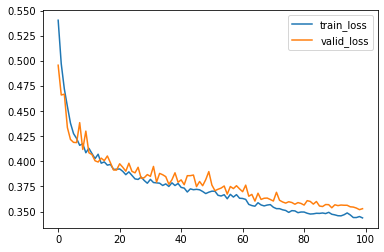

In [16]:
# . . plot the test and validation losses
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train_loss', 'valid_loss'])

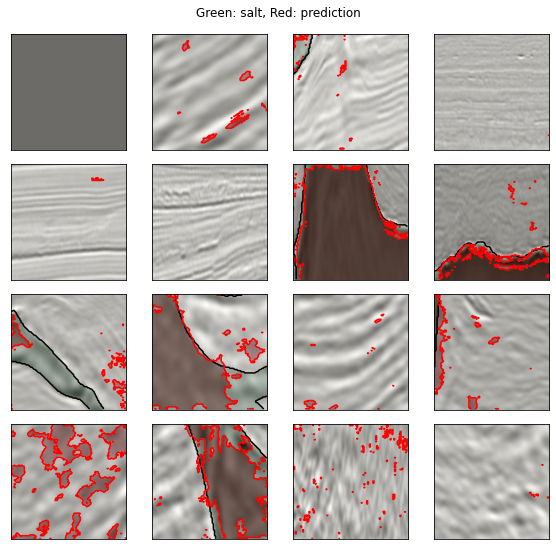

In [18]:
# . . test the trained network
# . . retrieve a new batch
images, masks_true = next(iter(validloader))
#images, masks_true = next(iter(trainloader))

# . . send images to device
images = images.to(device)
with torch.no_grad():
    # . . pass through the network
    outputs = trainer.model(images)

# . . send to CPU 
outputs    = outputs.cpu()

IoU = utils.get_iou_score(outputs, masks).numpy()

# . . convert images and masks to numpy
images     = images.cpu().numpy()
masks_true = masks_true.numpy()

masks_unet = torch.where((outputs)<0., torch.zeros_like(outputs), torch.ones_like(outputs)).numpy()

utils.compare_masks(images, masks_true, masks_unet, 4, 4, iou=None, figsize=(2,2))
#utils.plot_masks(images, masks_unet, 4, 4, figsize=(2,2))



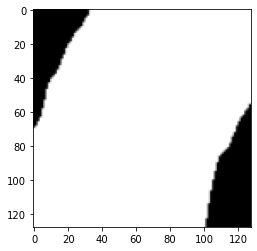

In [19]:
# . . run the trainer network to display output attention maps
sampleloader = DataLoader(dataset=valid_dataset, batch_size=500, num_workers=0, pin_memory=True)
#image, _ = iter(sampleloader).__next__()
image, mask = next(iter(sampleloader))
# . . 367, 262
iim = 67
plt.imshow(mask[iim,:,:,:].numpy().squeeze(), cmap='gray')
image = image[iim,:,:,:].view(1,1,128,128)
# . . send image to device
image = image.to(device)

torch.set_grad_enabled(False)
#trainer.model.eval()

# . . get the attention map
print('iscuda: ',image.is_cuda)
masknn, attention_list = trainer.model.forward_with_attention(image)

# . . send to cpu and split
# (b, nval, h, w)
att_map_1 = attention_list[0].cpu().numpy()
att_map_2 = attention_list[1].cpu().numpy()
att_map_3 = attention_list[2].cpu().numpy()
att_map_4 = attention_list[3].cpu().numpy()

# . . adjust the sizes of attention maps
b, c, h, w = att_map_1.shape
print(b, c, h, w)
#att1 = att_map_1.reshape((b, c, h*w))
#att1 = np.transpose(att1, (0,2,1))
#print(att1.shape)

#b, c, h, w = att_map_2.shape
#att2 = att_map_2.reshape((b, c, h*w))
#att2 = np.transpose(att2, (0,2,1))
#print(att2.shape)

#b, c, h, w = att_map_3.shape
#att3 = att_map_3.reshape((b, c, h*w))
#att3 = np.transpose(att3, (0,2,1))
#print(att3.shape)

b, c, h, w = att_map_4.shape
print(b, c, h, w)
plt.imshow(att_map_4.squeeze())
#att4 = att_map_4.reshape((b, c, h*w))
#att4 = np.transpose(att4, (0,2,1))
#print(att4.shape)

fig, ax = plt.subplots()
plt.imshow(image.cpu().numpy().squeeze(), cmap='gray')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.savefig("seismic.pdf", bbox_inches='tight', dpi=600)

from scipy.ndimage import gaussian_filter
att = att_map_4.squeeze()
attention = gaussian_filter(att, sigma=2)
fig, ax = plt.subplots()
plt.imshow(image.cpu().numpy().squeeze(), cmap='gray')
plt.imshow(attention, alpha=.5, cmap='RdGy_r')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.colorbar()
fig.savefig("attention.pdf", bbox_inches='tight', dpi=600)

fig, ax = plt.subplots()
plt.imshow(image.cpu().numpy().squeeze(), cmap='gray')
plt.imshow(masknn.cpu().squeeze(), cmap='OrRd', alpha=0.35)
plt.contour(masknn.cpu().squeeze(), colors='k', levels=[0.5], alpha=0.75)
#plt.imshow(mask[iim,:,:].cpu().squeeze(), cmap='Greens', alpha=0.35)
#plt.contour(mask[iim,:,:].cpu().squeeze(), colors='k', levels=[0.5], alpha=0.75)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.savefig("nnmask.pdf", bbox_inches='tight', dpi=600)

fig, ax = plt.subplots()
plt.imshow(image.cpu().numpy().squeeze(), cmap='gray')
#plt.imshow(masknn.cpu().squeeze(), cmap='OrRd', alpha=0.35)
#plt.contour(masknn.cpu().squeeze(), colors='k', levels=[0.5], alpha=0.75)
plt.imshow(mask[iim,:,:].cpu().squeeze(), cmap='Greens', alpha=0.35)
plt.contour(mask[iim,:,:].cpu().squeeze(), colors='k', levels=[0.5], alpha=0.75)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.savefig("gtmask.pdf", bbox_inches='tight', dpi=600)

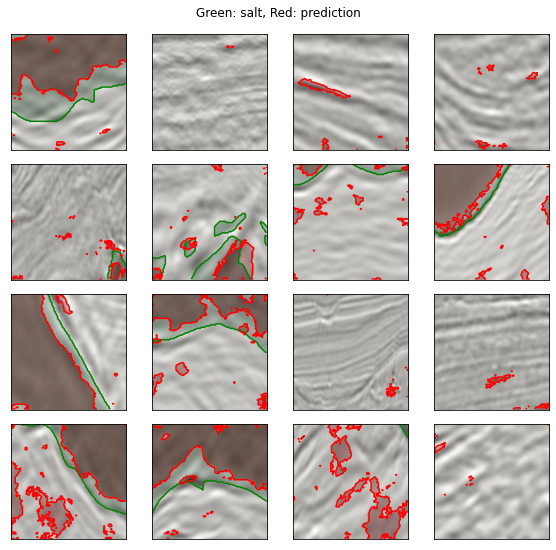

In [20]:
# (images, masks_true, masks_pred, nrows, ncols, iou=None, alpha=0.25, figsize=(5,5)
# . . test the trained network
# . . retrieve a new batch
images, masks_true = next(iter(trainloader))

# . . send images to device
images = images.to(device)
with torch.no_grad():
    # . . pass through the network
    outputs = trainer.model(images)

# . . send to CPU 
outputs    = outputs.cpu()

IoU = utils.get_iou_score(outputs, masks).numpy()

# . . convert images and masks to numpy
images     = images.cpu().numpy()
masks_true = masks_true.numpy()
#
masks_pred = torch.where((outputs)<0., torch.zeros_like(outputs), torch.ones_like(outputs)).numpy()

ncols = 4
nrows = 4
iou = None
alpha = 0.25
# . . adjust figsize
figsize = (2,2)
w, h = figsize
w *= ncols
h *= nrows
figsize = (w,h)

# . .number of figures
num_figs = nrows*ncols

# . . the number of images
num_images = len(images)
# . . generate random indexes
rand_idx = np.random.randint(0, num_images, num_figs) #generate random indexes

fig, ax = plt.subplots(nrows, ncols, squeeze=False, figsize=figsize)

idfig = 0
for j in range(nrows):
    for i in range(ncols):    
        ax[j,i].imshow(images[idfig,:,:,:].squeeze(), cmap='gray')
        ax[j,i].imshow( masks_true[idfig,:,:,:].squeeze(), cmap='Greens', alpha=alpha)
        ax[j,i].contour(masks_true[idfig,:,:,:].squeeze(), colors='g', levels=[0.5])
        ax[j,i].imshow( masks_pred[idfig,:,:,:].squeeze(), cmap='OrRd', alpha=alpha)
        ax[j,i].contour(masks_pred[idfig,:,:,:].squeeze(), colors='r', levels=[0.5])
        if iou is not None:
            ax[j,i].set_title("IoU: " + str(round(iou[idfig], 2)), loc = 'left')
        ax[j,i].axes.get_xaxis().set_visible(False)
        ax[j,i].axes.get_yaxis().set_visible(False)

        idfig += 1
plt.suptitle("Green: salt, Red: prediction")
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

#fig.savefig("seismic_4x8.pdf", bbox_inches='tight', dpi=600)
fig.savefig("mask_over_4x8.pdf", bbox_inches='tight', dpi=600)

In [ ]:
#out, enorm = model(images.to(device), enorm=True)

In [21]:
# . . retrieve a new batch
images, masks_true = next(iter(trainloader))

# . . send images to device
images = images.to(device)
with torch.no_grad():
    # . . pass through the network
    output, enorm = trainer.model(images, enorm=True)

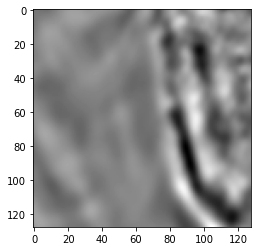

In [28]:
itrc=5
plt.imshow(images[itrc].cpu().numpy().squeeze(), cmap='gray')
#plt.imshow(masks_true[itrc].cpu().numpy().squeeze(), cmap='jet')

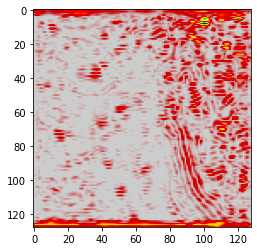

In [29]:
plt.imshow(enorm[itrc].cpu().numpy().squeeze(), cmap='nipy_spectral_r')